# One-zone models - effect of two-infall parameters

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import vice
import paths
from multizone.src.yields import J21
from multizone.src.models import twoinfall
from track_and_mdf import setup_figure, plot_vice_onezone
from vice.toolkit import J21_sf_law
from multizone.src import dtds

In [2]:
plt.style.use(paths.styles / 'paper.mplstyle')

In [3]:
parent_dir = paths.data / 'onezone' / 'twoinfall'
parent_dir.mkdir(parents=True, exist_ok=True)

In [4]:
dt = 0.01
tmax = 13.2
simtime = np.arange(0, tmax+dt, dt)

## Onset time

In [5]:
output_dir = parent_dir / 'onset'
output_dir.mkdir(parents=True, exist_ok=True)

In [6]:
def setup_onezone(name, func, r=8, dr=0.1, mode='ifr'):
    tau_star = J21_sf_law(np.pi * ((r+dr)**2 - r**2))
    sz = vice.singlezone(
        name=name,
        func=func,
        mode='ifr',
        elements=('fe', 'o'),
        eta=vice.milkyway.default_mass_loading(r),
        delay=0.04,
        RIa=dtds.exponential(timescale=1.5),
        Mg0=0,
        tau_star=tau_star,
        dt=dt,
        bins=[i*0.01 - 3 for i in range(401)],
    )
    return sz

Run one-zone models with different onset times for the second infall

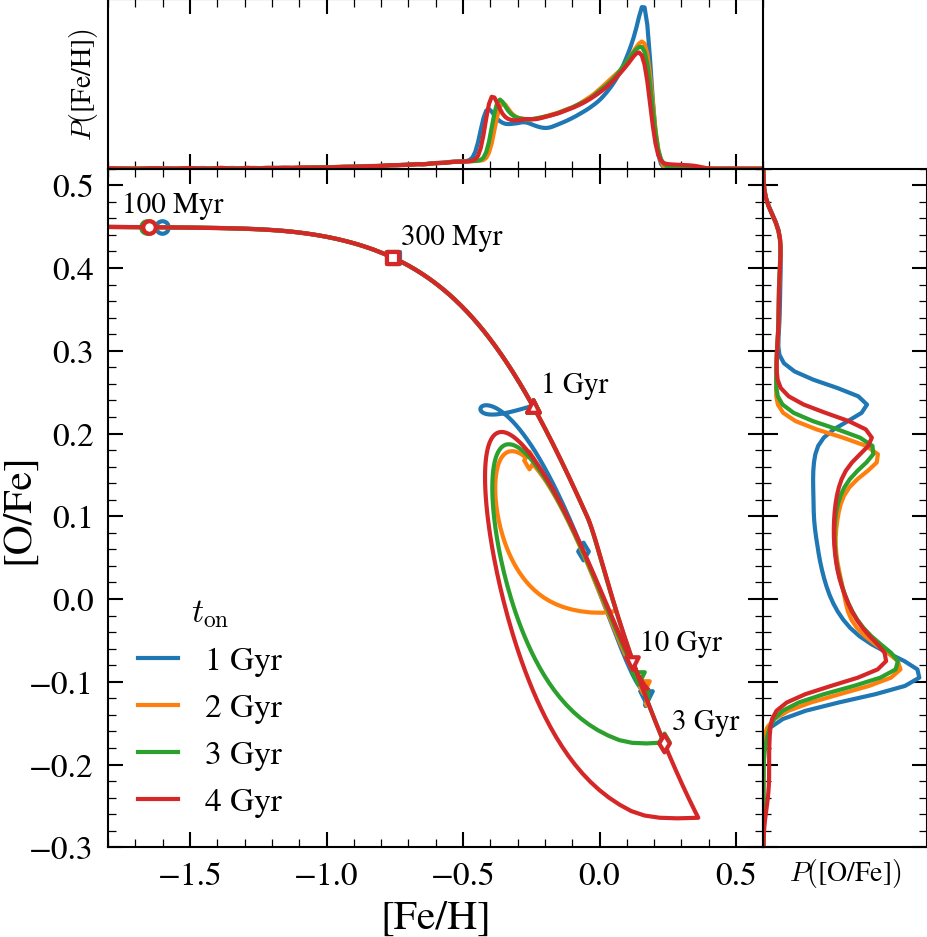

In [7]:
fig, axs = setup_figure(xlim=(-1.8, 0.6), ylim=(-0.3, 0.52))

onset_times = [1, 2, 3, 4]
for ton in onset_times:
    ifr = twoinfall(8, onset=ton)
    name = str(output_dir / f'onset{ton}')
    sz = setup_onezone(name, ifr)
    sz.run(simtime, overwrite=True)
    plot_vice_onezone(name, fig=fig, axs=axs,
                      label=f'{ton} Gyr',
                      marker_labels=(ton==4))

axs[1].set_ylim(bottom=0)
axs[2].set_xlim(left=0)
axs[0].legend(frameon=False, loc='lower left', title=r'$t_{\rm on}$')
plt.show()

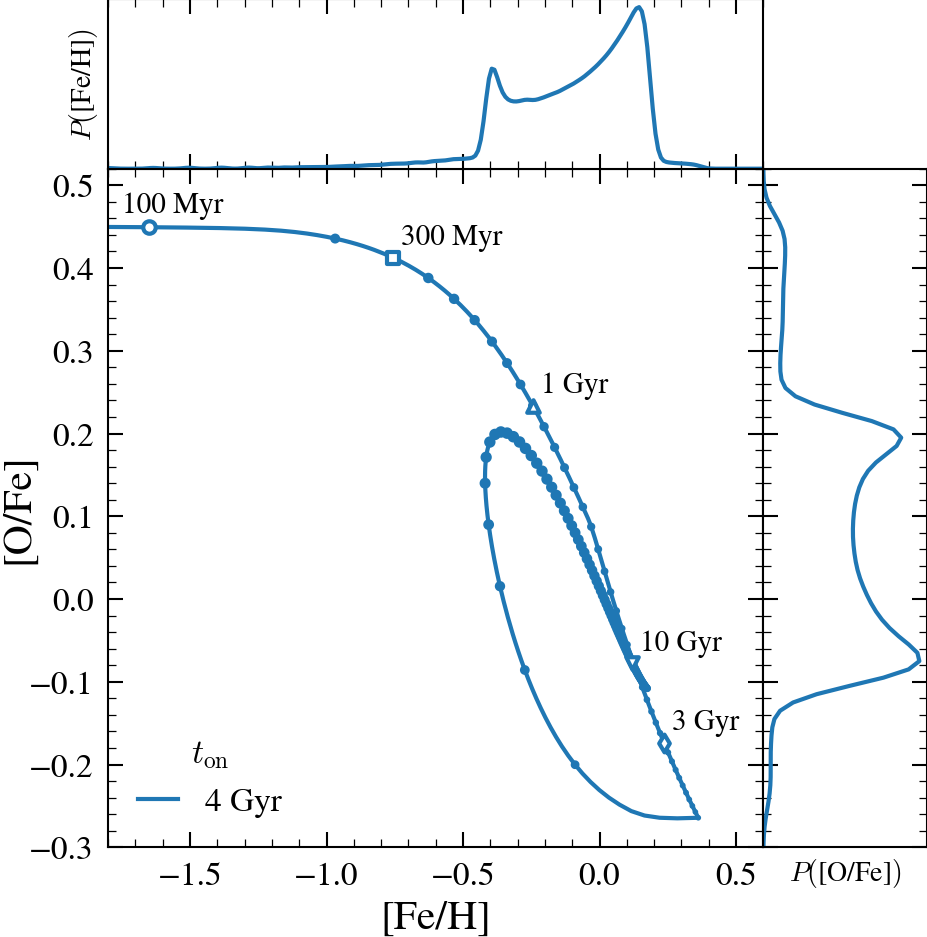

In [15]:
fig, axs = setup_figure(xlim=(-1.8, 0.6), ylim=(-0.3, 0.52))

name = str(output_dir / 'onset4')
plot_vice_onezone(name, fig=fig, axs=axs,
                  label=f'{ton} Gyr',
                  marker_labels=(ton==4))
hist = vice.history(name)
axs[0].scatter(hist['[fe/h]'][::10], hist['[o/fe]'][::10], s=[10*h for h in hist['sfr'][::10]])

axs[1].set_ylim(bottom=0)
axs[2].set_xlim(left=0)
axs[0].legend(frameon=False, loc='lower left', title=r'$t_{\rm on}$')
plt.show()

## Star formation efficiency

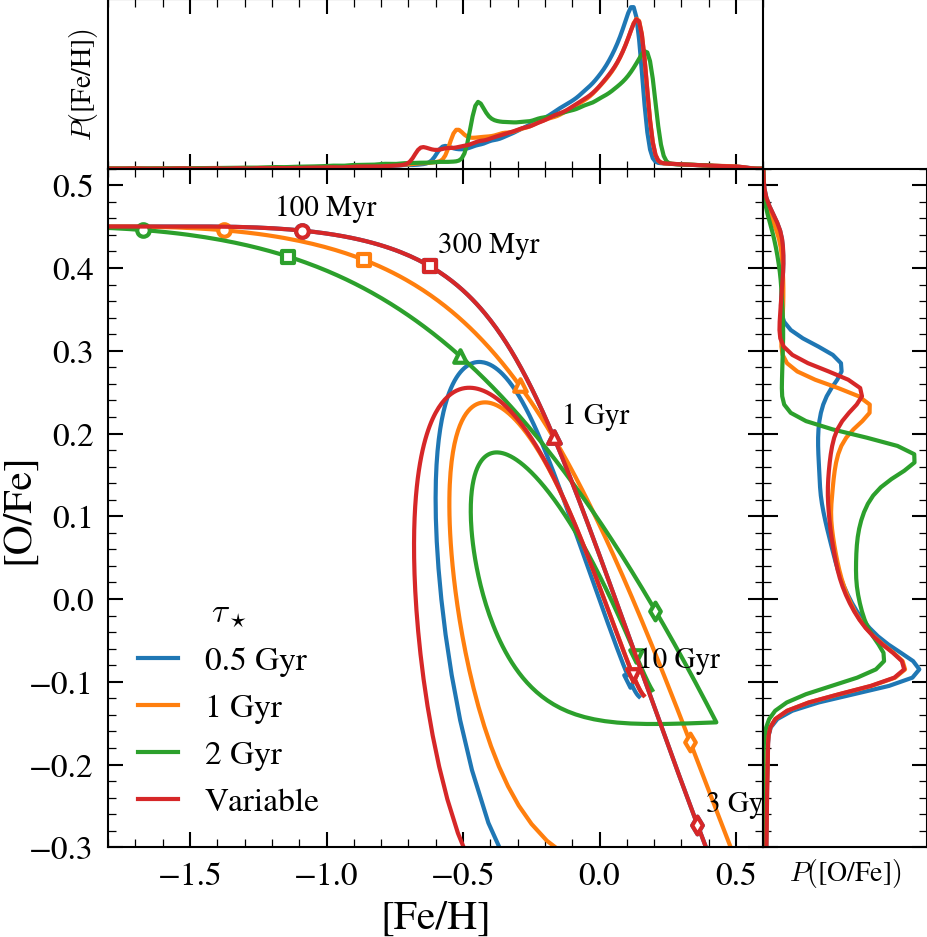

In [22]:
fig, axs = setup_figure(xlim=(-1.8, 0.6), ylim=(-0.3, 0.52))

ifr = twoinfall(8)

tau_star_list = [0.5, 1, 2]
for tau_star in tau_star_list:
    name = str(output_dir / f'taustar{int(tau_star*10)}')
    sz = vice.singlezone(
        name=name,
        func=ifr,
        mode='ifr',
        elements=('fe', 'o'),
        eta=vice.milkyway.default_mass_loading(8),
        delay=0.04,
        RIa=dtds.exponential(timescale=1.5),
        Mg0=0,
        tau_star=tau_star,
        dt=dt,
        bins=[i*0.01 - 3 for i in range(401)],
    )
    sz.run(simtime, overwrite=True)
    plot_vice_onezone(name, fig=fig, axs=axs,
                      label=f'{tau_star} Gyr',
                      marker_labels=(tau_star==0.5))

# Variable tau_star
def tau_star(t, onset=4):
    if t < onset:
        return 0.5
    else:
        return 1.

name = str(output_dir / 'taustar_var')
sz = vice.singlezone(
    name=name,
    func=ifr,
    mode='ifr',
    elements=('fe', 'o'),
    eta=vice.milkyway.default_mass_loading(8),
    delay=0.04,
    RIa=dtds.exponential(timescale=1.5),
    Mg0=0,
    tau_star=tau_star,
    dt=dt,
    bins=[i*0.01 - 3 for i in range(401)],
)
sz.run(simtime, overwrite=True)
plot_vice_onezone(name, fig=fig, axs=axs,
                  label='Variable',
                  marker_labels=False)

axs[1].set_ylim(bottom=0)
axs[2].set_xlim(left=0)
axs[0].legend(frameon=False, loc='lower left', title=r'$\tau_\star$')
plt.show()